In [1]:
%matplotlib  inline

# Train a CNN classifier and compare Normalized Margin
We are going to train a basic CNN model with or without batch normalization. Margins (normalized) will be shown along the training.

In [2]:
import os
import sys
import pickle
import torch
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import basic_cnn
#from collections import OrderedDict #if import basic_cnn, this line can be dropped
from utils import AverageMeter, accuracy, get_margin

#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

use_gpu = torch.cuda.is_available()

In [3]:
class CNN(nn.Module):
    def __init__(self, channels, output_size, with_bn=True):
        super(CNN, self).__init__()
        self.with_bn = with_bn
        self.features = self._make_layers(channels)
        self.classifier = nn.Linear(channels, output_size)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, channels):
        layers = []
        in_channels = 3
        for i in range(5):
            if i == 0:
                if self.with_bn:
                    layers += [('conv%d' % i, nn.Conv2d(in_channels, channels, 3, 2, 1)),
                               ('bn%d' % i, nn.BatchNorm2d(channels)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
                else:
                    layers += [('conv%d' % i, nn.Conv2d(in_channels, channels, 3, 2, 1)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
            else:
                if self.with_bn:
                    layers += [('conv%d' % i, nn.Conv2d(channels, channels, 3, 2, 1)),
                               ('bn%d' % i, nn.BatchNorm2d(channels)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
                else:
                    layers += [('conv%d' % i, nn.Conv2d(channels, channels, 3, 2, 1)),
                               ('relu%d' % i, nn.ReLU(inplace=True))]
        return nn.Sequential(OrderedDict(layers))

In [4]:
def train_model(model, criterion, optimizer, log_saver, num_epochs=100):
    since = time.time()
    steps = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        margin = []

        for phase in ['train', 'test']:

            loss_meter = AverageMeter()
            acc_meter = AverageMeter()

            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            for i, data in enumerate(loaders[phase]):
                inputs, labels_original = data
                labels = torch.FloatTensor(labels_original.size(0),10).zero_()
                labels.scatter_(1, labels_original.view(-1,1), 1)
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                    labels_original=labels_original.cuda()
                inputs = Variable(inputs)
                labels = Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    steps += 1
                    margin = np.append(margin, get_margin(outputs, labels_original))

                loss_meter.update(loss.data.item(), outputs.size(0))
                acc_meter.update(accuracy(outputs.data, labels_original.data)[-1].item(), outputs.size(0))

            epoch_loss = loss_meter.avg
            epoch_error = 1 - acc_meter.avg / 100

            if phase == 'train':

                log_saver['train_loss'].append(epoch_loss)
                log_saver['train_error'].append(epoch_error)
                log_saver['margin'].append(min(margin))
                ww = 1
                for i in range(6):
                    if i <= 4:
                        size = eval('model.features.conv%d.weight.size()' % i)
                        # here to compute the F norm between each CNN layer
                        #w_norm = eval('model.features.conv%d.weight.view(size[0],-1).pow(2).sum(1).mean().data.item()' % i)
                        #model.features.conv0.weight*model.features.bn0.weight[:,None,None,None]/(model.features.bn0.running_var.sqrt()[:,None,None,None]+1e-5)
                        scaled_w = eval('model.features.conv%d.weight*model.features.bn%d.weight[:,None,None,None]/(model.features.bn%d.running_var.sqrt()[:,None,None,None]+1e-5)' % (i,i,i))
                        w_norm = scaled_w.view(size[0],-1).pow(2).sum().sqrt().data.item()

                        log_saver['w%d' % i].append(w_norm)
                    else:
                        w_norm = model.classifier.weight.norm(2).data.item()
                        log_saver['w_fc'].append(w_norm)
                    ww *= w_norm
                log_saver['normalised_margin'].append(log_saver['margin'][-1] / ww)

            elif phase == 'test':

                log_saver['test_loss'].append(epoch_loss)
                log_saver['test_error'].append(epoch_error)

            print('{} Loss: {:.4f} Error: {:.4f}'.format(
                phase, epoch_loss, epoch_error), end=' ' if phase == 'train' else '\n')
            if phase == 'train':
                print('w4_norm: {:.4f} Margin: {:.4f} Norm_margin: {:.4f}'.format(log_saver['w4'][-1],
                                                                                  log_saver['margin'][-1],
                                                                                  log_saver['normalised_margin'][-1]))

        if epoch % 30 == 0 or epoch == num_epochs - 1:
            print('Saving..')
            state = {
                'net': model,
                'epoch': epoch,
                'log': log_saver
            }

            if not os.path.isdir('checkpoint_CNN'):
                os.mkdir('checkpoint_CNN')
            torch.save(state, './checkpoint_CNN/ckpt_epoch_{}.t7'.format(epoch))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model, log_saver


In [5]:
root = './'
lr = 0.01
BATCH_SIZE = 100
weight_decay = 0.

img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         (0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))])

In [6]:
training_dataset = datasets.CIFAR10(root, train=True, transform=img_transforms, download=True)
training_loader = DataLoader(training_dataset, BATCH_SIZE, shuffle=True, pin_memory=True)

testing_dataset = datasets.CIFAR10(root, train=False, transform=img_transforms)
testing_loader = DataLoader(testing_dataset, BATCH_SIZE, shuffle=False, pin_memory=True)

loaders = {'train': training_loader, 'test': testing_loader}

Files already downloaded and verified


## Train CNN with Batch-Normalization and Hinge Loss

In [7]:
log = {'num_params': [],
       'train_loss': [],
       'train_error': [],
       'test_loss': [],
       'test_error': [],
       'w0': [], 'w1': [], 'w2': [],
       'w3': [], 'w4': [], 'w_fc': [],
       'margin': [], 'normalised_margin': []}

# %% run the model
num_epochs = 100
channels = 100
# here use with_bn to control batch normalisation
model = basic_cnn.CNN(channels, 10, with_bn=True)

number_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
log['num_params'].append(number_params)

if use_gpu:
    model = model.cuda()

print('number-of-parameters:',log['num_params'])

for name, param in model.named_parameters(): #for name, param in model.state_dict().items():
    if param.requires_grad:
        print('Gradient updated parameter_name:',name)
        
for name1, param1 in model.state_dict().items():
    print('All parameter_name:',name1)

number-of-parameters: [365210]
Gradient updated parameter_name: features.conv0.weight
Gradient updated parameter_name: features.conv0.bias
Gradient updated parameter_name: features.bn0.weight
Gradient updated parameter_name: features.bn0.bias
Gradient updated parameter_name: features.conv1.weight
Gradient updated parameter_name: features.conv1.bias
Gradient updated parameter_name: features.bn1.weight
Gradient updated parameter_name: features.bn1.bias
Gradient updated parameter_name: features.conv2.weight
Gradient updated parameter_name: features.conv2.bias
Gradient updated parameter_name: features.bn2.weight
Gradient updated parameter_name: features.bn2.bias
Gradient updated parameter_name: features.conv3.weight
Gradient updated parameter_name: features.conv3.bias
Gradient updated parameter_name: features.bn3.weight
Gradient updated parameter_name: features.bn3.bias
Gradient updated parameter_name: features.conv4.weight
Gradient updated parameter_name: features.conv4.bias
Gradient upda

In [8]:
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

model, log = train_model(model, criterion, optimizer, log, num_epochs=num_epochs)


Epoch 1/100
----------
train Loss: 0.5369 Error: 0.7913 w4_norm: 22.5307 Margin: -2.0988 Norm_margin: -0.0000
test Loss: 0.4213 Error: 0.7180
Saving..
Epoch 2/100
----------
train Loss: 0.3686 Error: 0.6875 w4_norm: 21.2883 Margin: -1.8790 Norm_margin: -0.0000
test Loss: 0.3323 Error: 0.6638
Epoch 3/100
----------
train Loss: 0.3140 Error: 0.6441 w4_norm: 20.4385 Margin: -2.3117 Norm_margin: -0.0000
test Loss: 0.2998 Error: 0.6275
Epoch 4/100
----------
train Loss: 0.2908 Error: 0.6115 w4_norm: 19.9103 Margin: -2.8178 Norm_margin: -0.0000
test Loss: 0.2831 Error: 0.5918
Epoch 5/100
----------
train Loss: 0.2766 Error: 0.5868 w4_norm: 19.3922 Margin: -4.0494 Norm_margin: -0.0000
test Loss: 0.2708 Error: 0.5649
Epoch 6/100
----------
train Loss: 0.2658 Error: 0.5664 w4_norm: 19.3371 Margin: -4.0722 Norm_margin: -0.0000
test Loss: 0.2605 Error: 0.5478
Epoch 7/100
----------
train Loss: 0.2567 Error: 0.5480 w4_norm: 19.1674 Margin: -4.5968 Norm_margin: -0.0000
test Loss: 0.2523 Error: 0.53

test Loss: 0.1668 Error: 0.3449
Epoch 59/100
----------
train Loss: 0.0806 Error: 0.1285 w4_norm: 30.8170 Margin: -9.1967 Norm_margin: -0.0000
test Loss: 0.1692 Error: 0.3473
Epoch 60/100
----------
train Loss: 0.0788 Error: 0.1236 w4_norm: 31.2434 Margin: -9.4904 Norm_margin: -0.0000
test Loss: 0.1678 Error: 0.3455
Epoch 61/100
----------
train Loss: 0.0766 Error: 0.1185 w4_norm: 31.3359 Margin: -8.4046 Norm_margin: -0.0000
test Loss: 0.1696 Error: 0.3462
Saving..
Epoch 62/100
----------
train Loss: 0.0748 Error: 0.1146 w4_norm: 31.5713 Margin: -9.6020 Norm_margin: -0.0000
test Loss: 0.1718 Error: 0.3539
Epoch 63/100
----------
train Loss: 0.0728 Error: 0.1107 w4_norm: 31.7107 Margin: -9.5348 Norm_margin: -0.0000
test Loss: 0.1712 Error: 0.3501
Epoch 64/100
----------
train Loss: 0.0706 Error: 0.1058 w4_norm: 32.4980 Margin: -10.6142 Norm_margin: -0.0000
test Loss: 0.1734 Error: 0.3477
Epoch 65/100
----------
train Loss: 0.0690 Error: 0.1008 w4_norm: 33.2452 Margin: -8.8784 Norm_margi

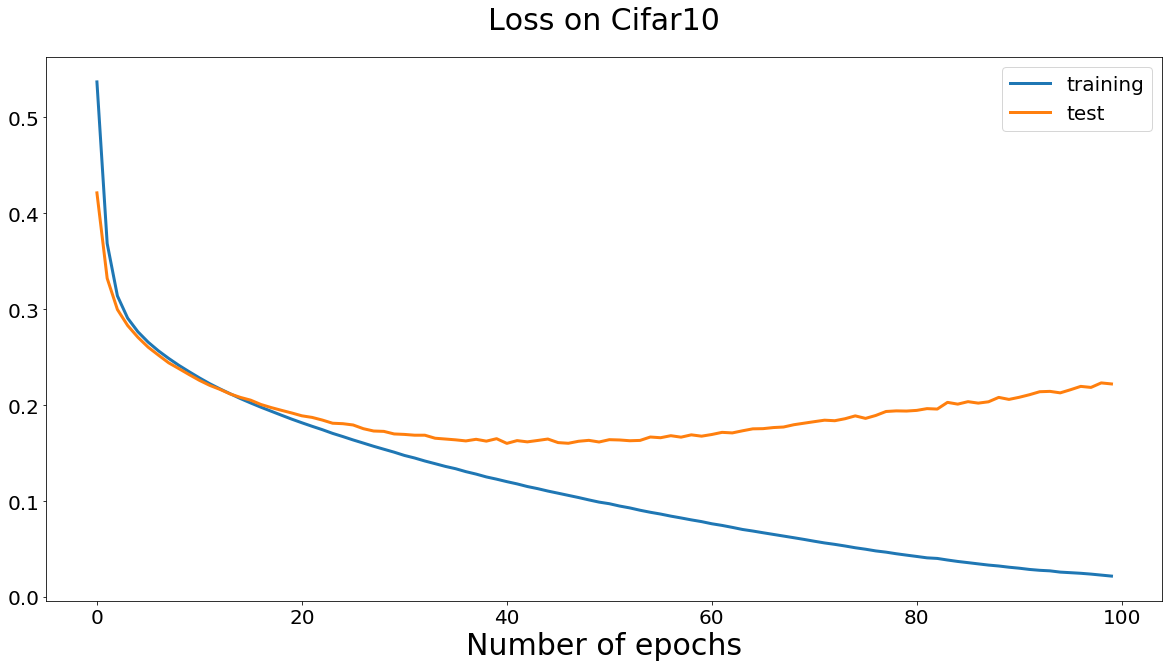

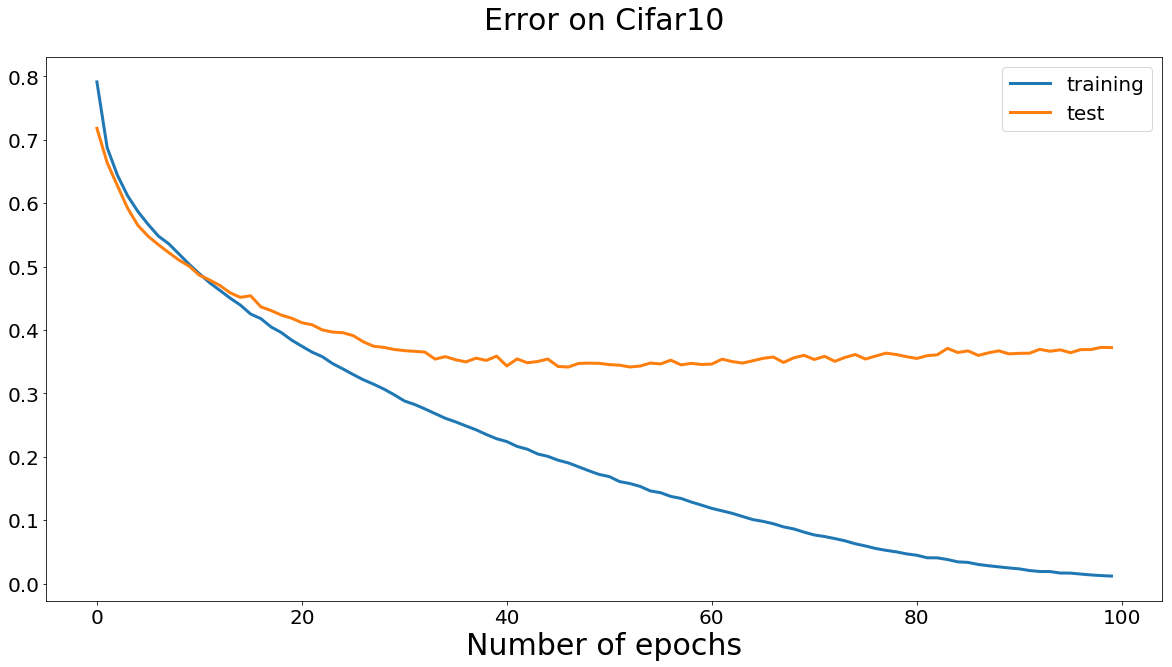

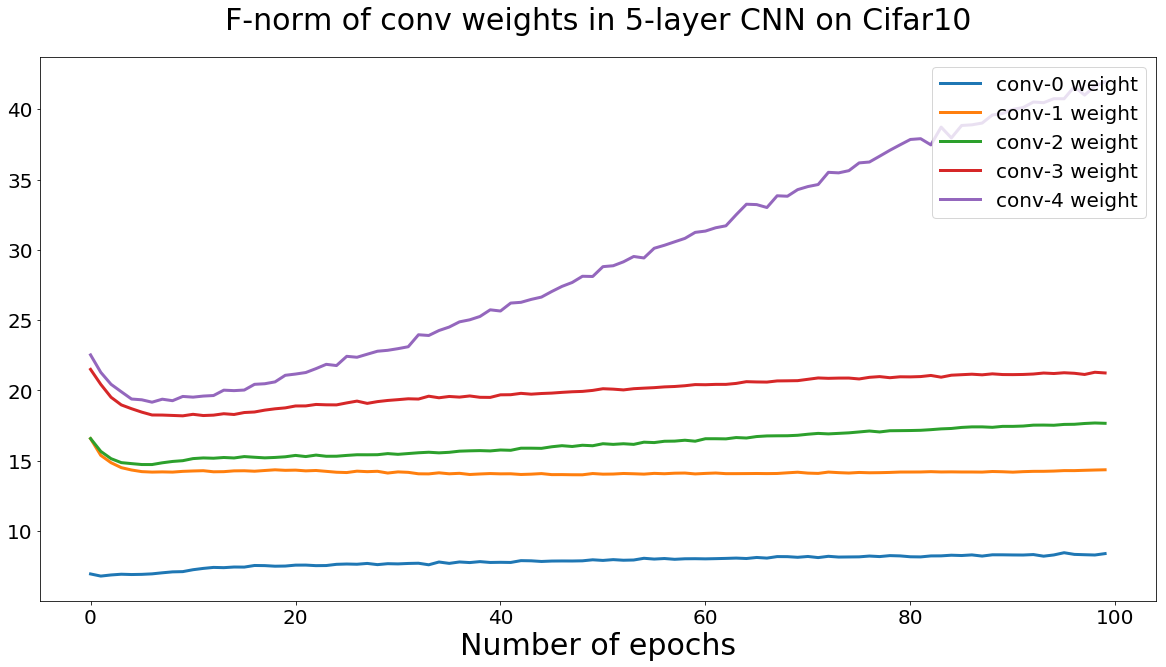

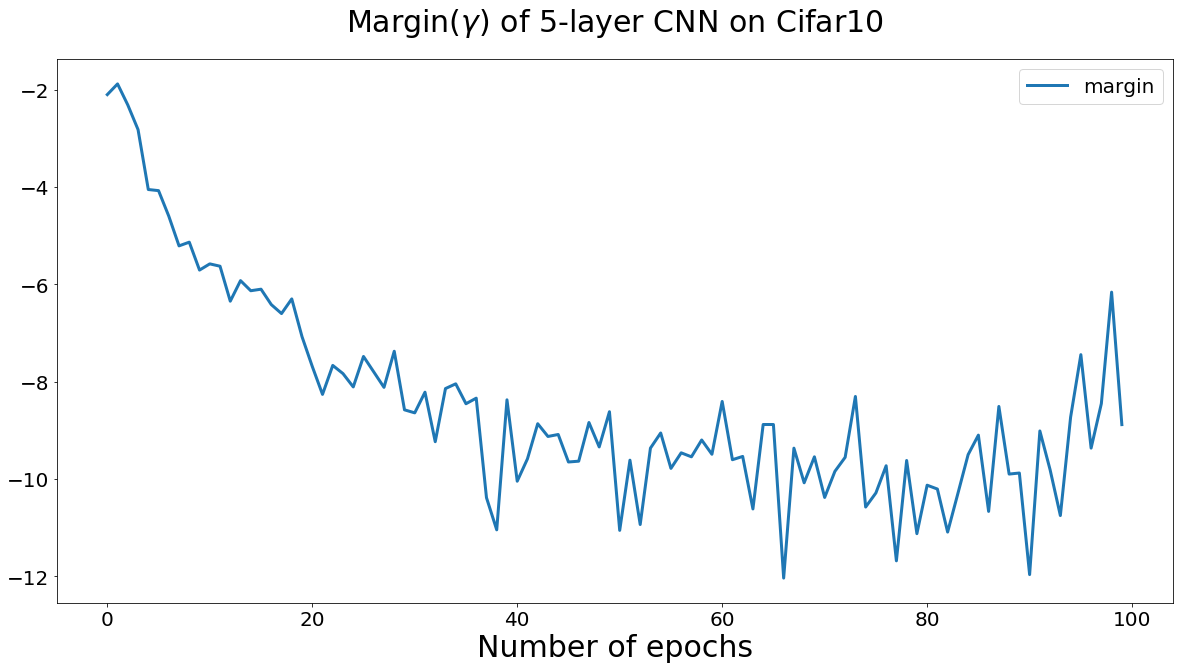

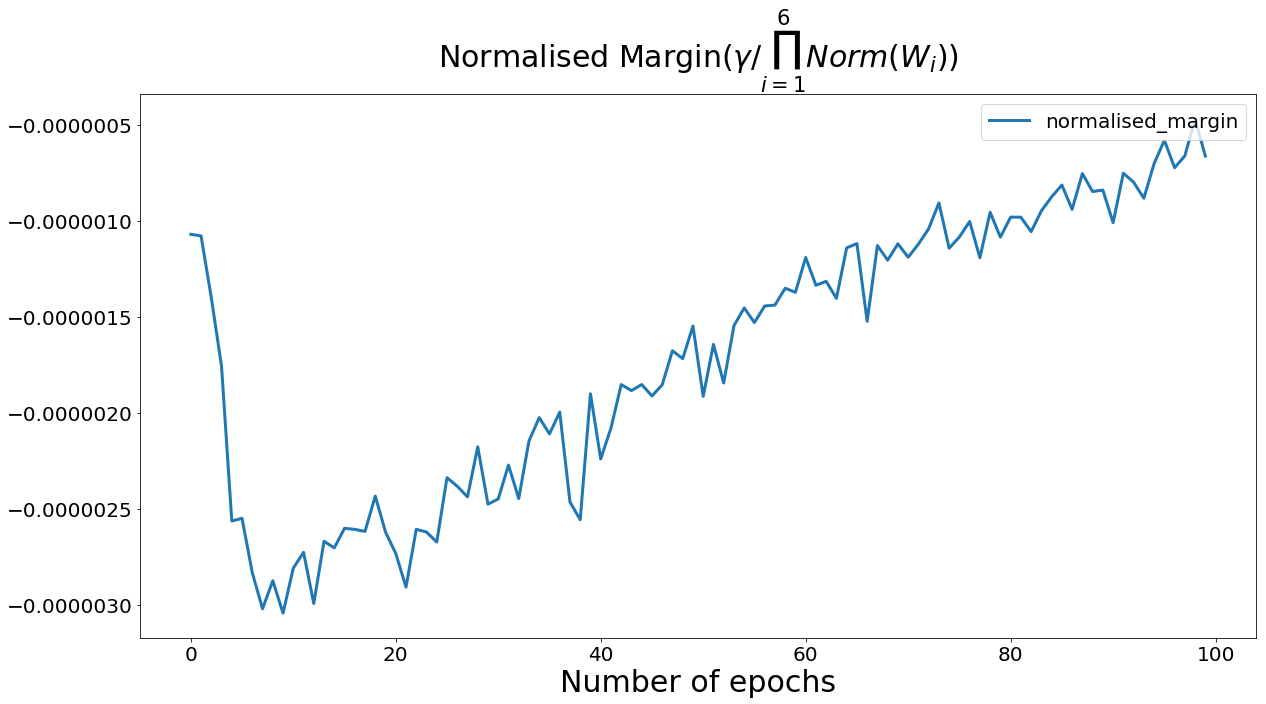

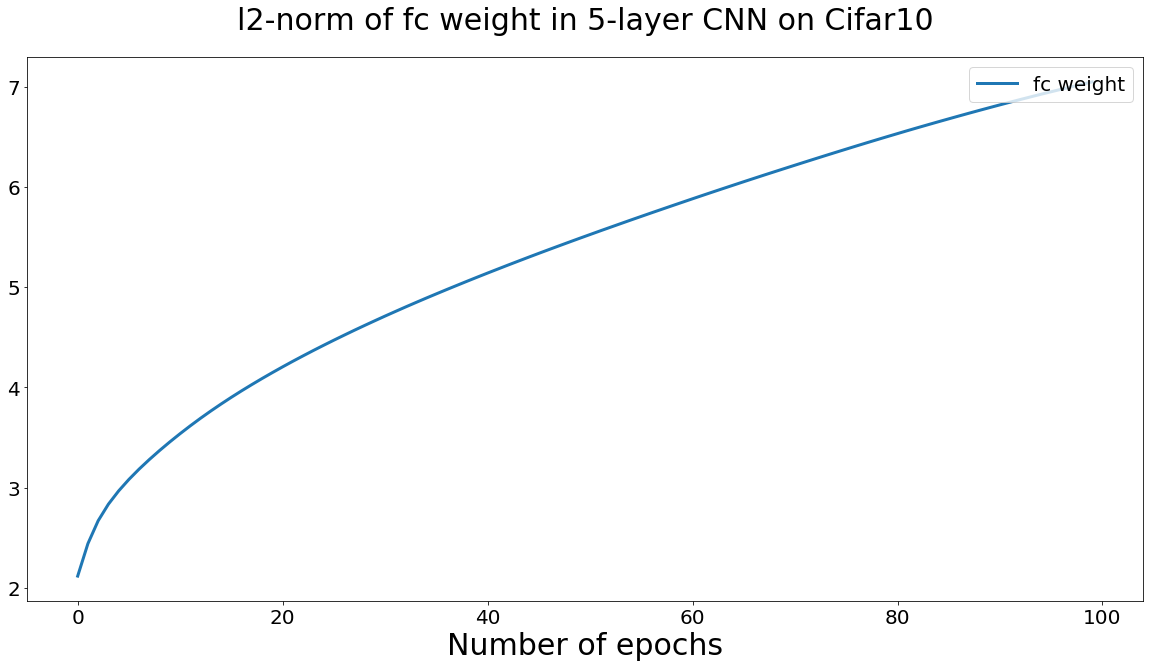

In [9]:
# %% show the results
def plot():
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig3, ax3 = get_fig(3, 'F-norm of conv weights in 5-layer CNN on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, 'Normalised Margin($\gamma/\prod_{i=1}^{6}Norm(W_{i})$)')
    fig6, ax6 = get_fig(6, 'l2-norm of fc weight in 5-layer CNN on Cifar10')

    ax1.plot(log['train_loss'], linewidth=3, label='training')
    ax1.plot(log['test_loss'], linewidth=3, label='test')
    ax2.plot(log['train_error'], linewidth=3, label='training')
    ax2.plot(log['test_error'], linewidth=3, label='test')

    for i in range(5):
        ax3.plot(log['w%d' % i], linewidth=3, label='conv-%d weight' % i)

    ax4.plot(log['margin'], linewidth=3, label='margin')
    ax5.plot(log['normalised_margin'], linewidth=3, label='normalised_margin')
    ax6.plot(log['w_fc'], linewidth=3, label='fc weight')

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    result_dir = './results_bn/'
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss%d.png' % channels)
    fig2.savefig(result_dir + 'error%d.png' % channels)
    fig3.savefig(result_dir + 'conv_weight%d.png' % channels)
    fig4.savefig(result_dir + 'margin%d.png' % channels)
    fig5.savefig(result_dir + 'n_margin%d.png' % channels)
    fig6.savefig(result_dir + 'fc_weight%d.png' % channels)


plot()
plt.show()

In [10]:
# Train another 100 epochs more...
model, log = train_model(model, criterion, optimizer, log, num_epochs=num_epochs)

Epoch 1/100
----------
train Loss: 0.0212 Error: 0.0099 w4_norm: 42.3560 Margin: -9.3930 Norm_margin: -0.0000
test Loss: 0.2235 Error: 0.3702
Saving..
Epoch 2/100
----------
train Loss: 0.0210 Error: 0.0100 w4_norm: 42.6566 Margin: -8.4869 Norm_margin: -0.0000
test Loss: 0.2283 Error: 0.3691
Epoch 3/100
----------
train Loss: 0.0201 Error: 0.0089 w4_norm: 42.5641 Margin: -11.6981 Norm_margin: -0.0000
test Loss: 0.2290 Error: 0.3719
Epoch 4/100
----------
train Loss: 0.0195 Error: 0.0083 w4_norm: 43.6850 Margin: -8.7385 Norm_margin: -0.0000
test Loss: 0.2297 Error: 0.3699
Epoch 5/100
----------
train Loss: 0.0187 Error: 0.0075 w4_norm: 43.2697 Margin: -10.2464 Norm_margin: -0.0000
test Loss: 0.2289 Error: 0.3697
Epoch 6/100
----------
train Loss: 0.0180 Error: 0.0072 w4_norm: 43.1893 Margin: -9.8216 Norm_margin: -0.0000
test Loss: 0.2278 Error: 0.3714
Epoch 7/100
----------
train Loss: 0.0174 Error: 0.0060 w4_norm: 43.3862 Margin: -7.7487 Norm_margin: -0.0000
test Loss: 0.2336 Error: 0.

test Loss: 0.2791 Error: 0.3807
Epoch 59/100
----------
train Loss: 0.0052 Error: 0.0002 w4_norm: 49.7957 Margin: -4.7810 Norm_margin: -0.0000
test Loss: 0.2840 Error: 0.3847
Epoch 60/100
----------
train Loss: 0.0052 Error: 0.0003 w4_norm: 49.8621 Margin: -1.7871 Norm_margin: -0.0000
test Loss: 0.2828 Error: 0.3818
Epoch 61/100
----------
train Loss: 0.0051 Error: 0.0003 w4_norm: 50.1989 Margin: -2.8995 Norm_margin: -0.0000
test Loss: 0.2865 Error: 0.3857
Saving..
Epoch 62/100
----------
train Loss: 0.0049 Error: 0.0001 w4_norm: 49.8902 Margin: -2.5642 Norm_margin: -0.0000
test Loss: 0.2862 Error: 0.3866
Epoch 63/100
----------
train Loss: 0.0049 Error: 0.0002 w4_norm: 50.0563 Margin: -3.7478 Norm_margin: -0.0000
test Loss: 0.2861 Error: 0.3830
Epoch 64/100
----------
train Loss: 0.0048 Error: 0.0001 w4_norm: 49.4956 Margin: -1.7119 Norm_margin: -0.0000
test Loss: 0.2851 Error: 0.3859
Epoch 65/100
----------
train Loss: 0.0047 Error: 0.0002 w4_norm: 50.0529 Margin: -1.3188 Norm_margin

In [11]:
# Train another 100 epochs more...
model, log = train_model(model, criterion, optimizer, log, num_epochs=num_epochs)

Epoch 1/100
----------
train Loss: 0.0031 Error: 0.0001 w4_norm: 52.6384 Margin: -1.9895 Norm_margin: -0.0000
test Loss: 0.3069 Error: 0.3848
Saving..
Epoch 2/100
----------
train Loss: 0.0030 Error: 0.0000 w4_norm: 52.5620 Margin: -0.5312 Norm_margin: -0.0000
test Loss: 0.3109 Error: 0.3848
Epoch 3/100
----------
train Loss: 0.0029 Error: 0.0000 w4_norm: 52.4657 Margin: -0.6195 Norm_margin: -0.0000
test Loss: 0.3073 Error: 0.3863
Epoch 4/100
----------
train Loss: 0.0028 Error: 0.0001 w4_norm: 52.3435 Margin: -1.0839 Norm_margin: -0.0000
test Loss: 0.3095 Error: 0.3844
Epoch 5/100
----------
train Loss: 0.0029 Error: 0.0000 w4_norm: 52.8378 Margin: -0.8984 Norm_margin: -0.0000
test Loss: 0.3113 Error: 0.3821
Epoch 6/100
----------
train Loss: 0.0029 Error: 0.0000 w4_norm: 52.3728 Margin: 0.1587 Norm_margin: 0.0000
test Loss: 0.3112 Error: 0.3850
Epoch 7/100
----------
train Loss: 0.0028 Error: 0.0000 w4_norm: 51.8868 Margin: -1.1750 Norm_margin: -0.0000
test Loss: 0.3089 Error: 0.3890

test Loss: 0.3276 Error: 0.3921
Epoch 59/100
----------
train Loss: 0.0018 Error: 0.0000 w4_norm: 54.6611 Margin: 0.1052 Norm_margin: 0.0000
test Loss: 0.3319 Error: 0.3879
Epoch 60/100
----------
train Loss: 0.0018 Error: 0.0001 w4_norm: 54.1653 Margin: -1.3161 Norm_margin: -0.0000
test Loss: 0.3290 Error: 0.3887
Epoch 61/100
----------
train Loss: 0.0018 Error: 0.0001 w4_norm: 54.8137 Margin: -2.8913 Norm_margin: -0.0000
test Loss: 0.3360 Error: 0.3906
Saving..
Epoch 62/100
----------
train Loss: 0.0017 Error: 0.0001 w4_norm: 54.5529 Margin: -2.0986 Norm_margin: -0.0000
test Loss: 0.3331 Error: 0.3881
Epoch 63/100
----------
train Loss: 0.0017 Error: 0.0000 w4_norm: 54.5725 Margin: 0.0375 Norm_margin: 0.0000
test Loss: 0.3327 Error: 0.3920
Epoch 64/100
----------
train Loss: 0.0018 Error: 0.0001 w4_norm: 54.8894 Margin: -4.8086 Norm_margin: -0.0000
test Loss: 0.3331 Error: 0.3895
Epoch 65/100
----------
train Loss: 0.0017 Error: 0.0000 w4_norm: 54.3849 Margin: -0.8196 Norm_margin: -0

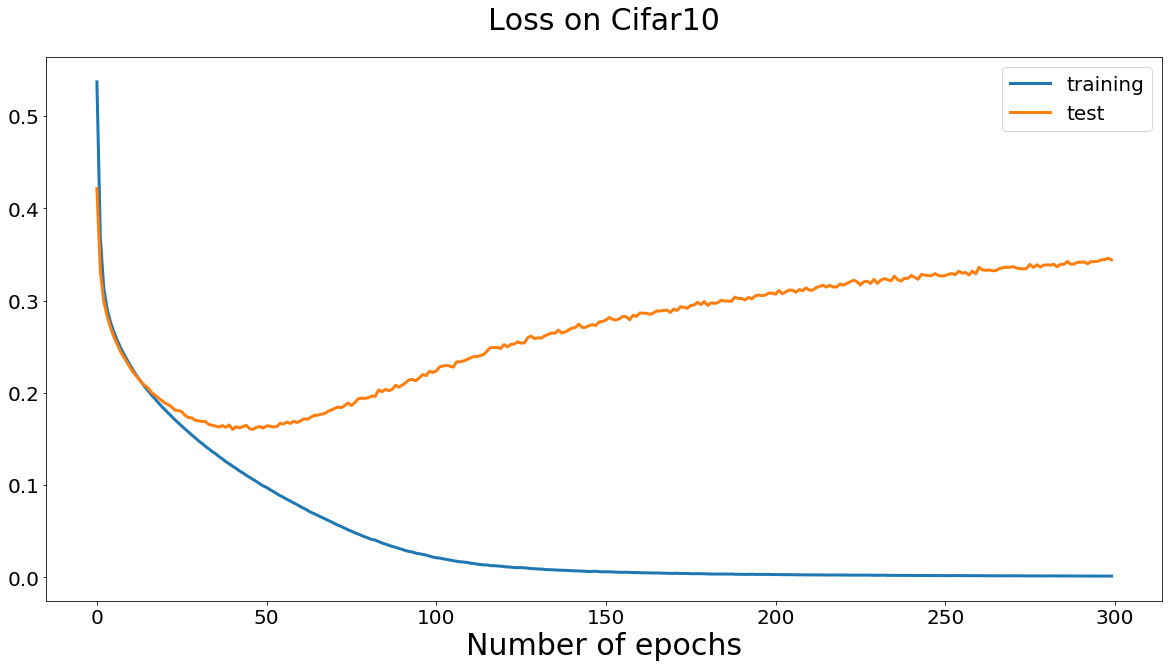

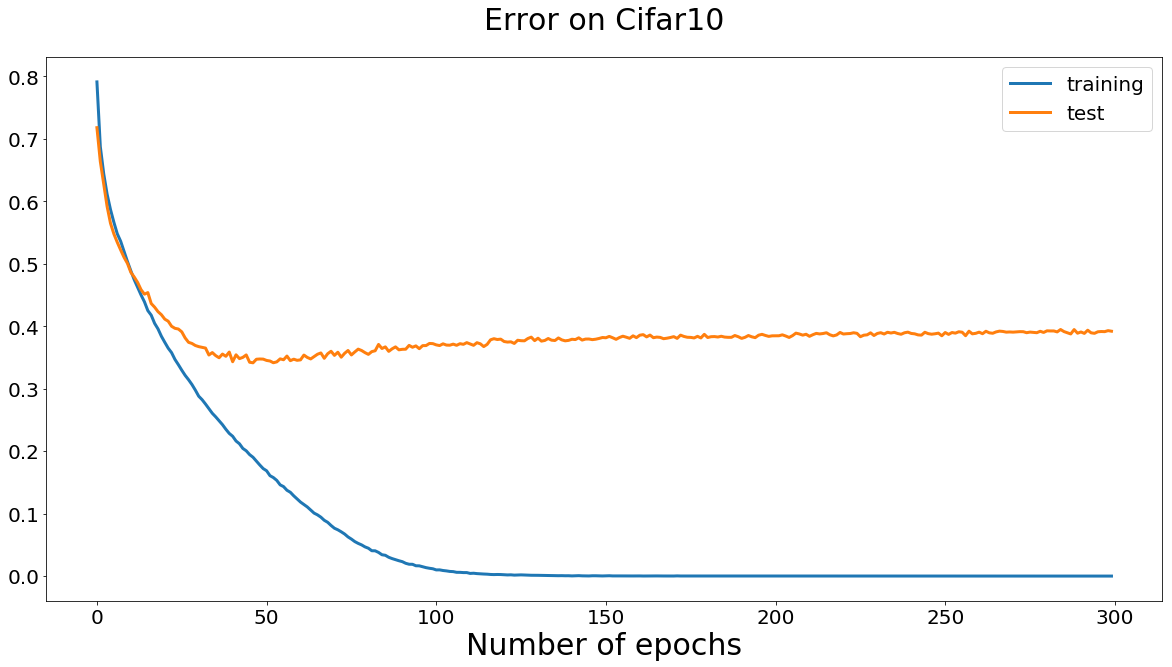

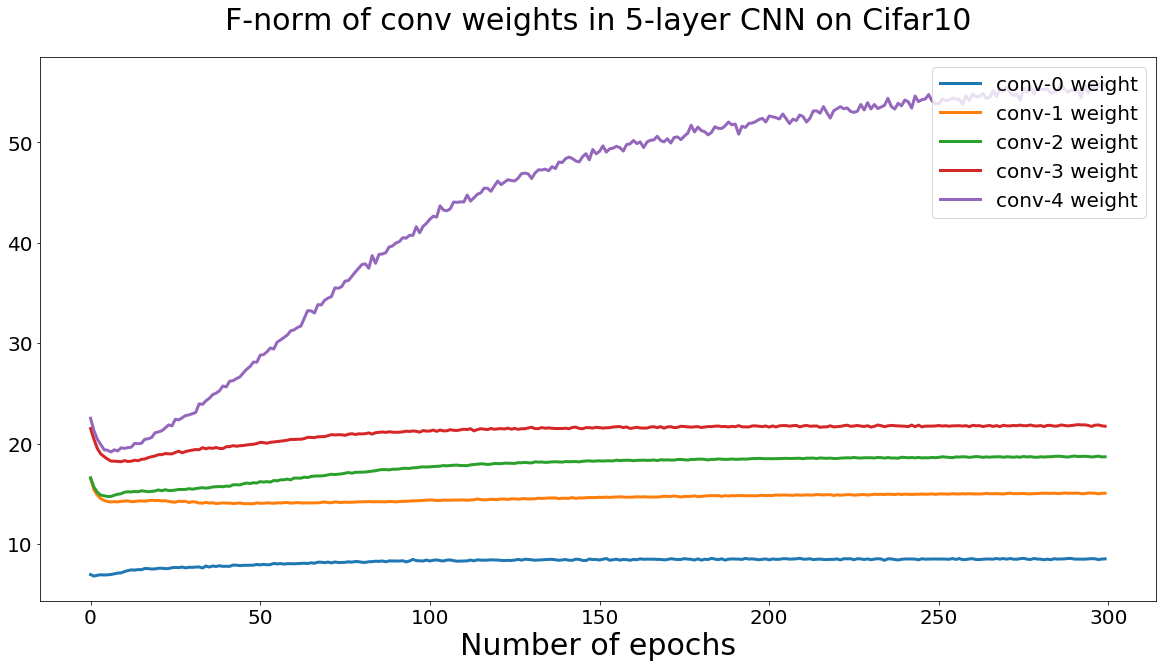

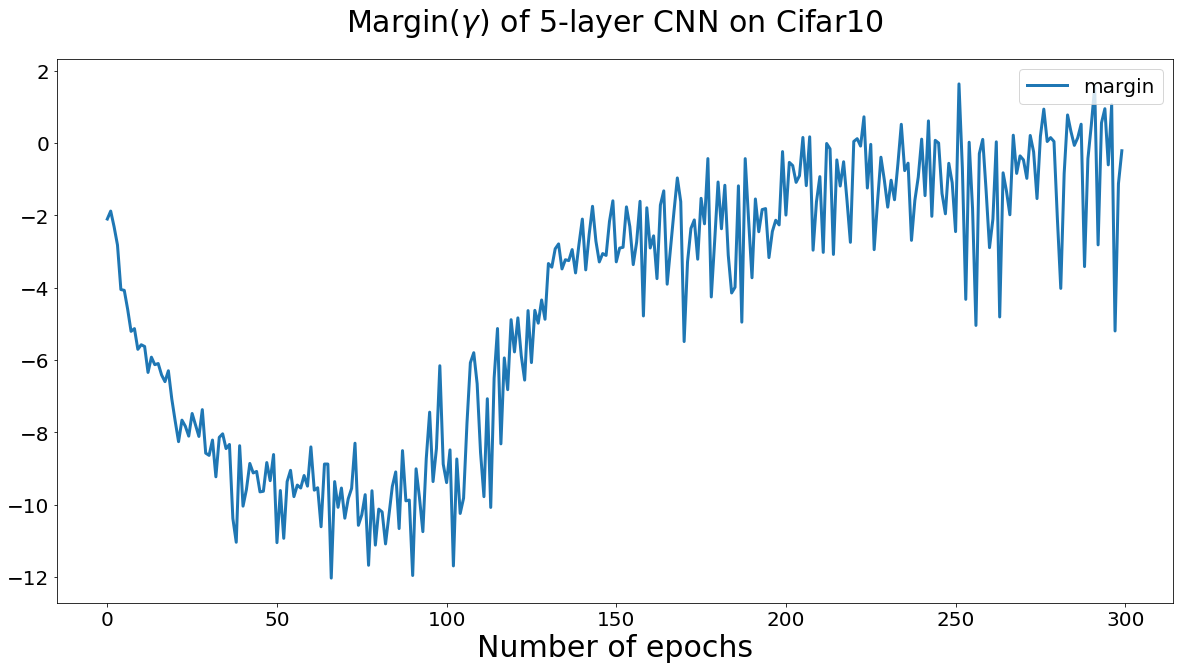

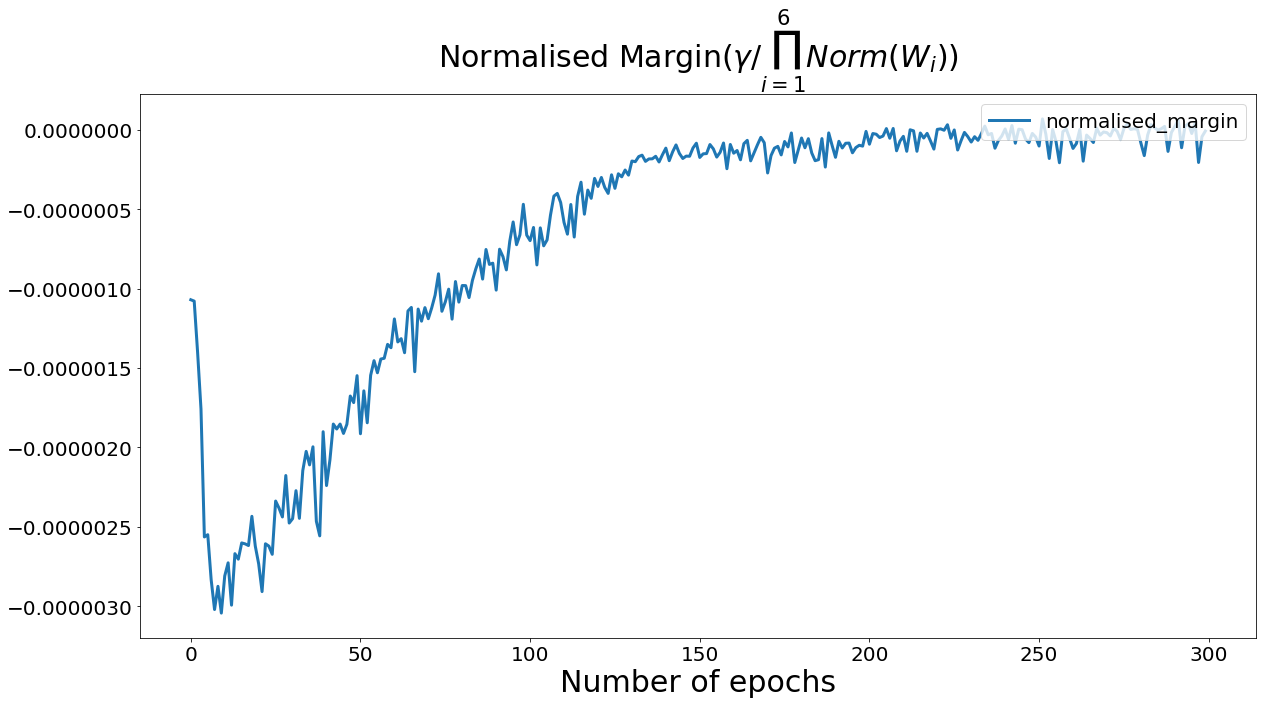

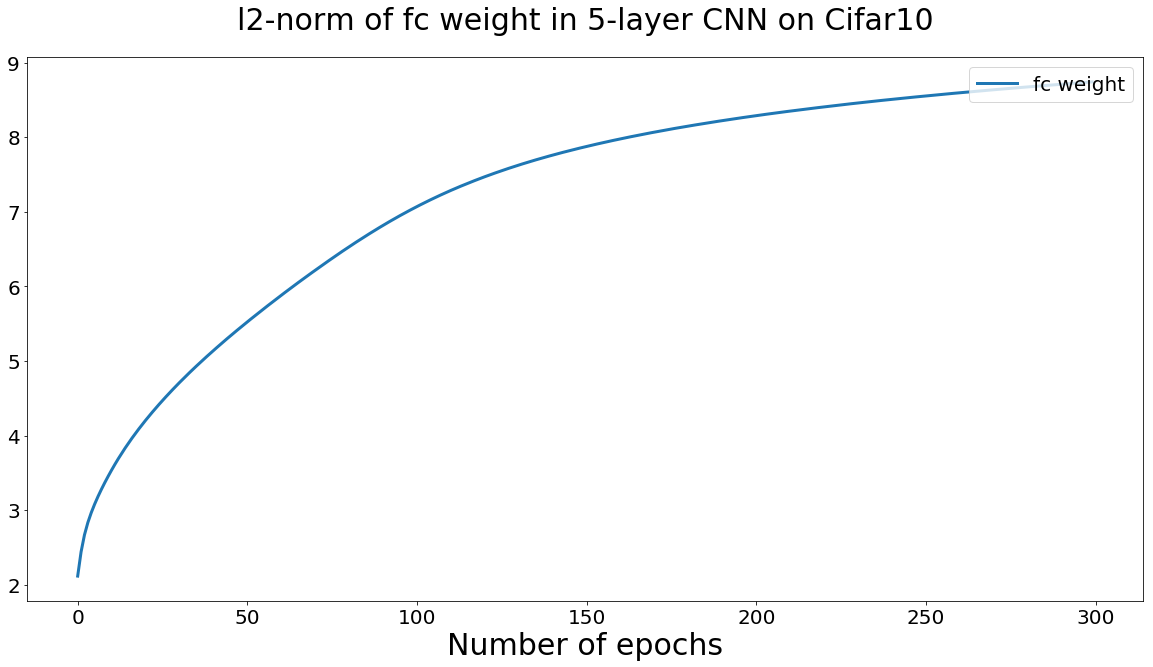

In [12]:
# %% show the results
def plot():
    fontdict = {'size': 30}

    def get_fig(i, title):
        fig = plt.figure(i, figsize=(20, 10))
        ax = fig.add_subplot(111)
        plt.title(title, fontsize=30, y=1.04)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        return fig, ax

    fig1, ax1 = get_fig(1, 'Loss on Cifar10')
    fig2, ax2 = get_fig(2, 'Error on Cifar10')
    fig3, ax3 = get_fig(3, 'F-norm of conv weights in 5-layer CNN on Cifar10')
    fig4, ax4 = get_fig(4, 'Margin($\gamma$) of 5-layer CNN on Cifar10')
    fig5, ax5 = get_fig(5, 'Normalised Margin($\gamma/\prod_{i=1}^{6}Norm(W_{i})$)')
    fig6, ax6 = get_fig(6, 'l2-norm of fc weight in 5-layer CNN on Cifar10')

    ax1.plot(log['train_loss'], linewidth=3, label='training')
    ax1.plot(log['test_loss'], linewidth=3, label='test')
    ax2.plot(log['train_error'], linewidth=3, label='training')
    ax2.plot(log['test_error'], linewidth=3, label='test')

    for i in range(5):
        ax3.plot(log['w%d' % i], linewidth=3, label='conv-%d weight' % i)

    ax4.plot(log['margin'], linewidth=3, label='margin')
    ax5.plot(log['normalised_margin'], linewidth=3, label='normalised_margin')
    ax6.plot(log['w_fc'], linewidth=3, label='fc weight')

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_xlabel('Number of epochs', fontdict=fontdict)
        ax.legend(loc='upper right', fontsize=20)

    result_dir = './results_bn/'
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    fig1.savefig(result_dir + 'loss%d.png' % channels)
    fig2.savefig(result_dir + 'error%d.png' % channels)
    fig3.savefig(result_dir + 'conv_weight%d.png' % channels)
    fig4.savefig(result_dir + 'margin%d.png' % channels)
    fig5.savefig(result_dir + 'n_margin%d.png' % channels)
    fig6.savefig(result_dir + 'fc_weight%d.png' % channels)


plot()
plt.show()